# Test 3 SOM on Kepler and TESS Data

The third test done on the dataset combined with the Kepler and TESS data processed with the Min Max technique. Using the dataset without under-sampling, but eliminating some anomalous characteristics and initializing the SOM weights with 50% composed of Planet values taken randomly, and 50% False Planets.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

from sklearn.model_selection import train_test_split
from simple_som.som_grid_search import SOMGridSearch
from simple_som.som import SimpleSOM
from simple_som.visualization import View
from utils.color import Color
from utils.util import print_count_nan, plot_confusion_matrix
from utils.ditance_metrics import DistanceMetrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [2]:
X_train = pd.read_csv('../data/processed_data/X_kepler_tess.csv')
y_train = pd.read_csv('../data/processed_data/y_kepler_tess.csv')
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print_count_nan(data=X_train, name='X_train')
print_count_nan(data=y_train, name='y_train')
print('X Col', X_train.columns)
print('y Col', y_train.columns)

Shape of X_train: (13798, 18)
Shape of y_train: (13798, 2)
Number of not a numbers values in X_train: 0 out of 248364: 0.00%
Number of not a numbers values in y_train: 0 out of 27596: 0.00%
X Col Index(['Unnamed: 0', 'Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar Mass (M_Sun)',
       'Stellar Mass (M_Sun) err', 'TESS Mag'],
      dtype='object')
y Col Index(['Unnamed: 0', '0'], dtype='object')


In [3]:
X_train = X_train.drop(columns=['Unnamed: 0','Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
                                'Stellar log(g) (cm/s^2)', 'TESS Mag'])

In [4]:
print('X Col', X_train.columns)
print('y Col', y_train.columns)

X Col Index(['Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Mass (M_Sun)', 'Stellar Mass (M_Sun) err'],
      dtype='object')
y Col Index(['Unnamed: 0', '0'], dtype='object')


In [5]:
component_names = ['Period (days)', 'Period (days) err', 'Duration (hours)',
       'Duration (hours) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth) err', 'Planet Radius (R_Earth)',
       'Planet Equil Temp (K)', 'Planet Insolation (Earth Flux)', 'Planet SNR',
       'Stellar Mass (M_Sun)', 'Stellar Mass (M_Sun) err']

In [6]:
X_train = X_train.values
y_train = y_train.drop(columns='Unnamed: 0').values

In [7]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True,
                                                    stratify=None)
print("Number of X_train: ", X_train.shape[0])
print("Number of X_test: ", X_test.shape[0])
print("Number of features: ", X_train.shape[1])

Number of X_train:  11038
Number of X_test:  2760
Number of features:  13


# Grid Search

In [8]:
param_grid = {
    'W': [None],
    'max_iter': [10000],
    'num_rows': [15, 20, 30],
    'num_cols': [15, 20, 30],
    'max_learning_rate': [0.8],
    'max_distance': [10],
    'distance_bmu': [DistanceMetrics.euclidean_distance, DistanceMetrics.manhattan_distance],
    'distance_nr': [DistanceMetrics.euclidean_distance, DistanceMetrics.manhattan_distance],
    'W_PLANET': [0.9],
    'W_FALSE_PLANET': [1],
    'K': [5, 7, 9]
}

In [9]:
# grid_search = SOMGridSearch(param_grid=param_grid, n_jobs=4)
# best_param, best_score = grid_search.fit(X_train, y_train, X_test, y_test)

# print("Best param:", best_param)
# print("Best accuracy:", best_score)
#################################################################################
# Best param: {'W': None, 'max_iter': 14000, 'num_rows': 20, 'num_cols': 20,
# 'max_learning_rate': 0.8, 'max_distance': 10,
# 'distance_bmu': <function DistanceMetrics.manhattan_distance at 0x2b3852fc0700>,
# 'distance_nr': <function DistanceMetrics.manhattan_distance at 0x2b3852fc0700>,
# 'W_PLANET': 0.9, 'W_FALSE_PLANET': 1, 'K': 7}
# Best accuracy: 0.775
#################################################################################
# Best param: {'W': None, 'max_iter': 10000, 'num_rows': 30, 'num_cols': 15,
# 'max_learning_rate': 0.8, 'max_distance': 10,
# 'distance_bmu': <function DistanceMetrics.manhattan_distance at 0x7f580509ede0>,
# 'distance_nr': <function DistanceMetrics.euclidean_distance at 0x7f580509ed40>,
# 'W_PLANET': 0.9, 'W_FALSE_PLANET': 1, 'K': 7}
# Best accuracy: 0.7648550724637682

In [10]:
best_param = {}
best_param['W'] = None
best_param['max_iter'] = 100000
best_param['num_rows'] = 20
best_param['num_cols'] = 20
best_param['max_learning_rate'] = 0.8
best_param['max_distance'] = 10
best_param['distance_bmu'] = DistanceMetrics.manhattan_distance
best_param['distance_nr'] = DistanceMetrics.manhattan_distance
best_param['W_PLANET'] = 0.9
best_param['W_FALSE_PLANET'] = 1
best_param['K'] = 7

In [11]:
W = best_param['W']
max_iter = 100000 # best_param['max_iter']
num_rows = best_param['num_rows']
num_cols = best_param['num_cols']
max_learning_rate = best_param['max_learning_rate']
max_distance = best_param['max_distance']
distance_bmu = best_param['distance_bmu']
distance_nr = best_param['distance_nr']
w_planet = best_param['W_PLANET']
w_false_planet = best_param['W_FALSE_PLANET']
K = best_param['K']

In [12]:
som = SimpleSOM(X_train=X_train, y_train=y_train, W=None, max_iter=max_iter, 
                num_rows=num_rows, num_cols=num_cols, max_learning_rate=max_learning_rate,
                max_distance=max_distance, distance_bmu=distance_bmu, distance_nr=distance_nr, 
                W_PLANET=w_planet, W_FALSE_PLANET=w_false_planet, K=K, n_jobs=4)
params = som.fit(X_data=X_train, verbose=2)

Iteration:  00001  | QE:    0.000003  | LR:    0.800000  | NR:   10.000000  | Time:    0.008889


Iteration:  01000  | QE:    0.000003  | LR:    0.792008  | NR:   10.000000  | Time:    3.440380
Iteration:  02000  | QE:    0.000006  | LR:    0.784008  | NR:   10.000000  | Time:    2.768755
Iteration:  03000  | QE:    0.000001  | LR:    0.776008  | NR:   10.000000  | Time:    2.828360
Iteration:  04000  | QE:    0.000009  | LR:    0.768008  | NR:   10.000000  | Time:    2.681971
Iteration:  05000  | QE:    0.000004  | LR:    0.760008  | NR:   10.000000  | Time:    2.941608
Iteration:  06000  | QE:    0.000004  | LR:    0.752008  | NR:   10.000000  | Time:    3.163815
Iteration:  07000  | QE:    0.000005  | LR:    0.744008  | NR:   10.000000  | Time:    3.029823
Iteration:  08000  | QE:    0.000005  | LR:    0.736008  | NR:   10.000000  | Time:    3.348351
Iteration:  09000  | QE:    0.000003  | LR:    0.728008  | NR:   10.000000  | Time:    3.536463
Iteration:  10000  | QE:    0.000003  | LR:    0.720008  | NR:   10.000000  | Time:    3.269434
Iteration:  11000  | QE:    0.000002  | 

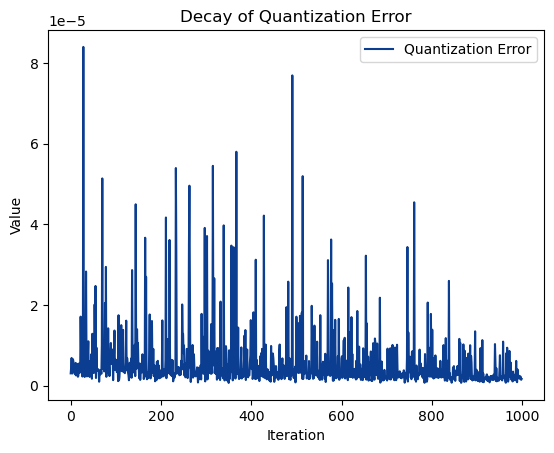

In [13]:
REDUCE = 100
plt.plot(range(max_iter//REDUCE), params['errors'][::REDUCE], 
         label='Quantization Error', color=Color.SEA.value)
plt.title('Decay of Quantization Error')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

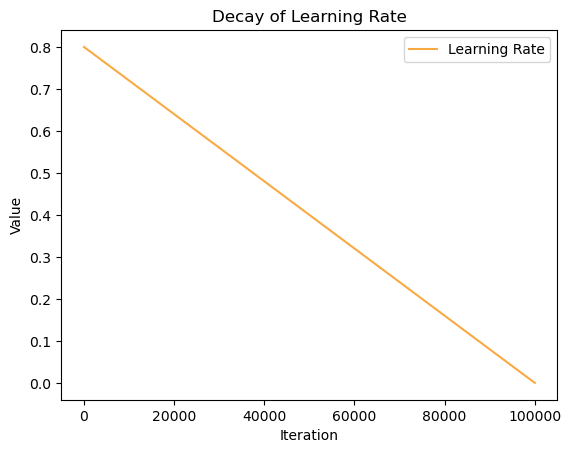

In [14]:
plt.plot(range(max_iter), params['lr'], label='Learning Rate', color=Color.SUN.value)
plt.title('Decay of Learning Rate')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

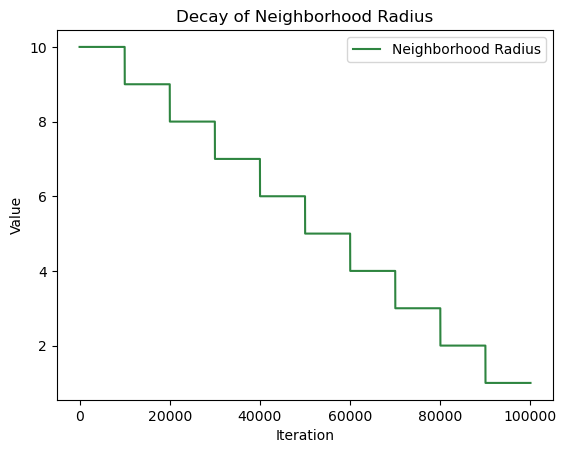

In [15]:
plt.plot(range(max_iter), params['nr'], label='Neighborhood Radius', color=Color.EARTH.value)
plt.title('Decay of Neighborhood Radius')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.show()

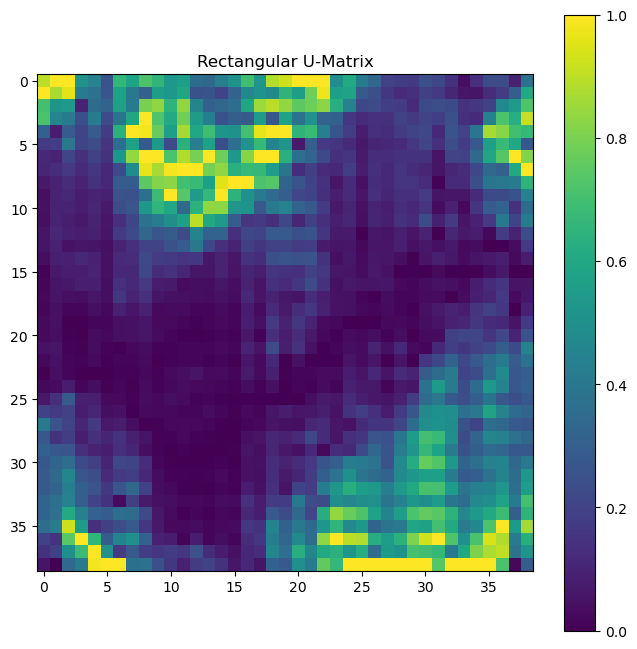

In [16]:
u_matrix_rect = View.make_u_rect(som=som)
plt.figure(figsize=(8, 8))
plt.imshow(u_matrix_rect, cmap='viridis', interpolation='none')
plt.title('Rectangular U-Matrix')
plt.colorbar()
plt.show()

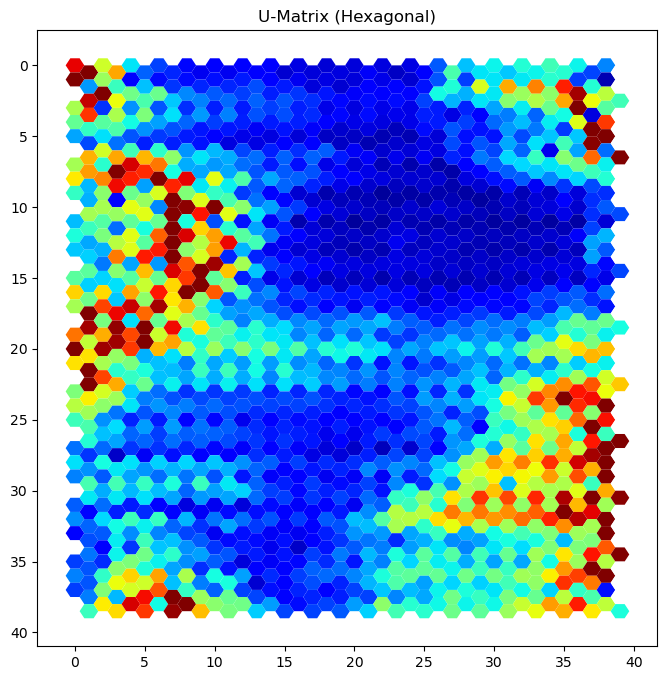

In [17]:
u_matrix_hex = View.make_u_hex(som=som)
fig, ax = plt.subplots(figsize=(8,8))
View.draw_hex_grid(som, ax, u_matrix_hex)
plt.show()

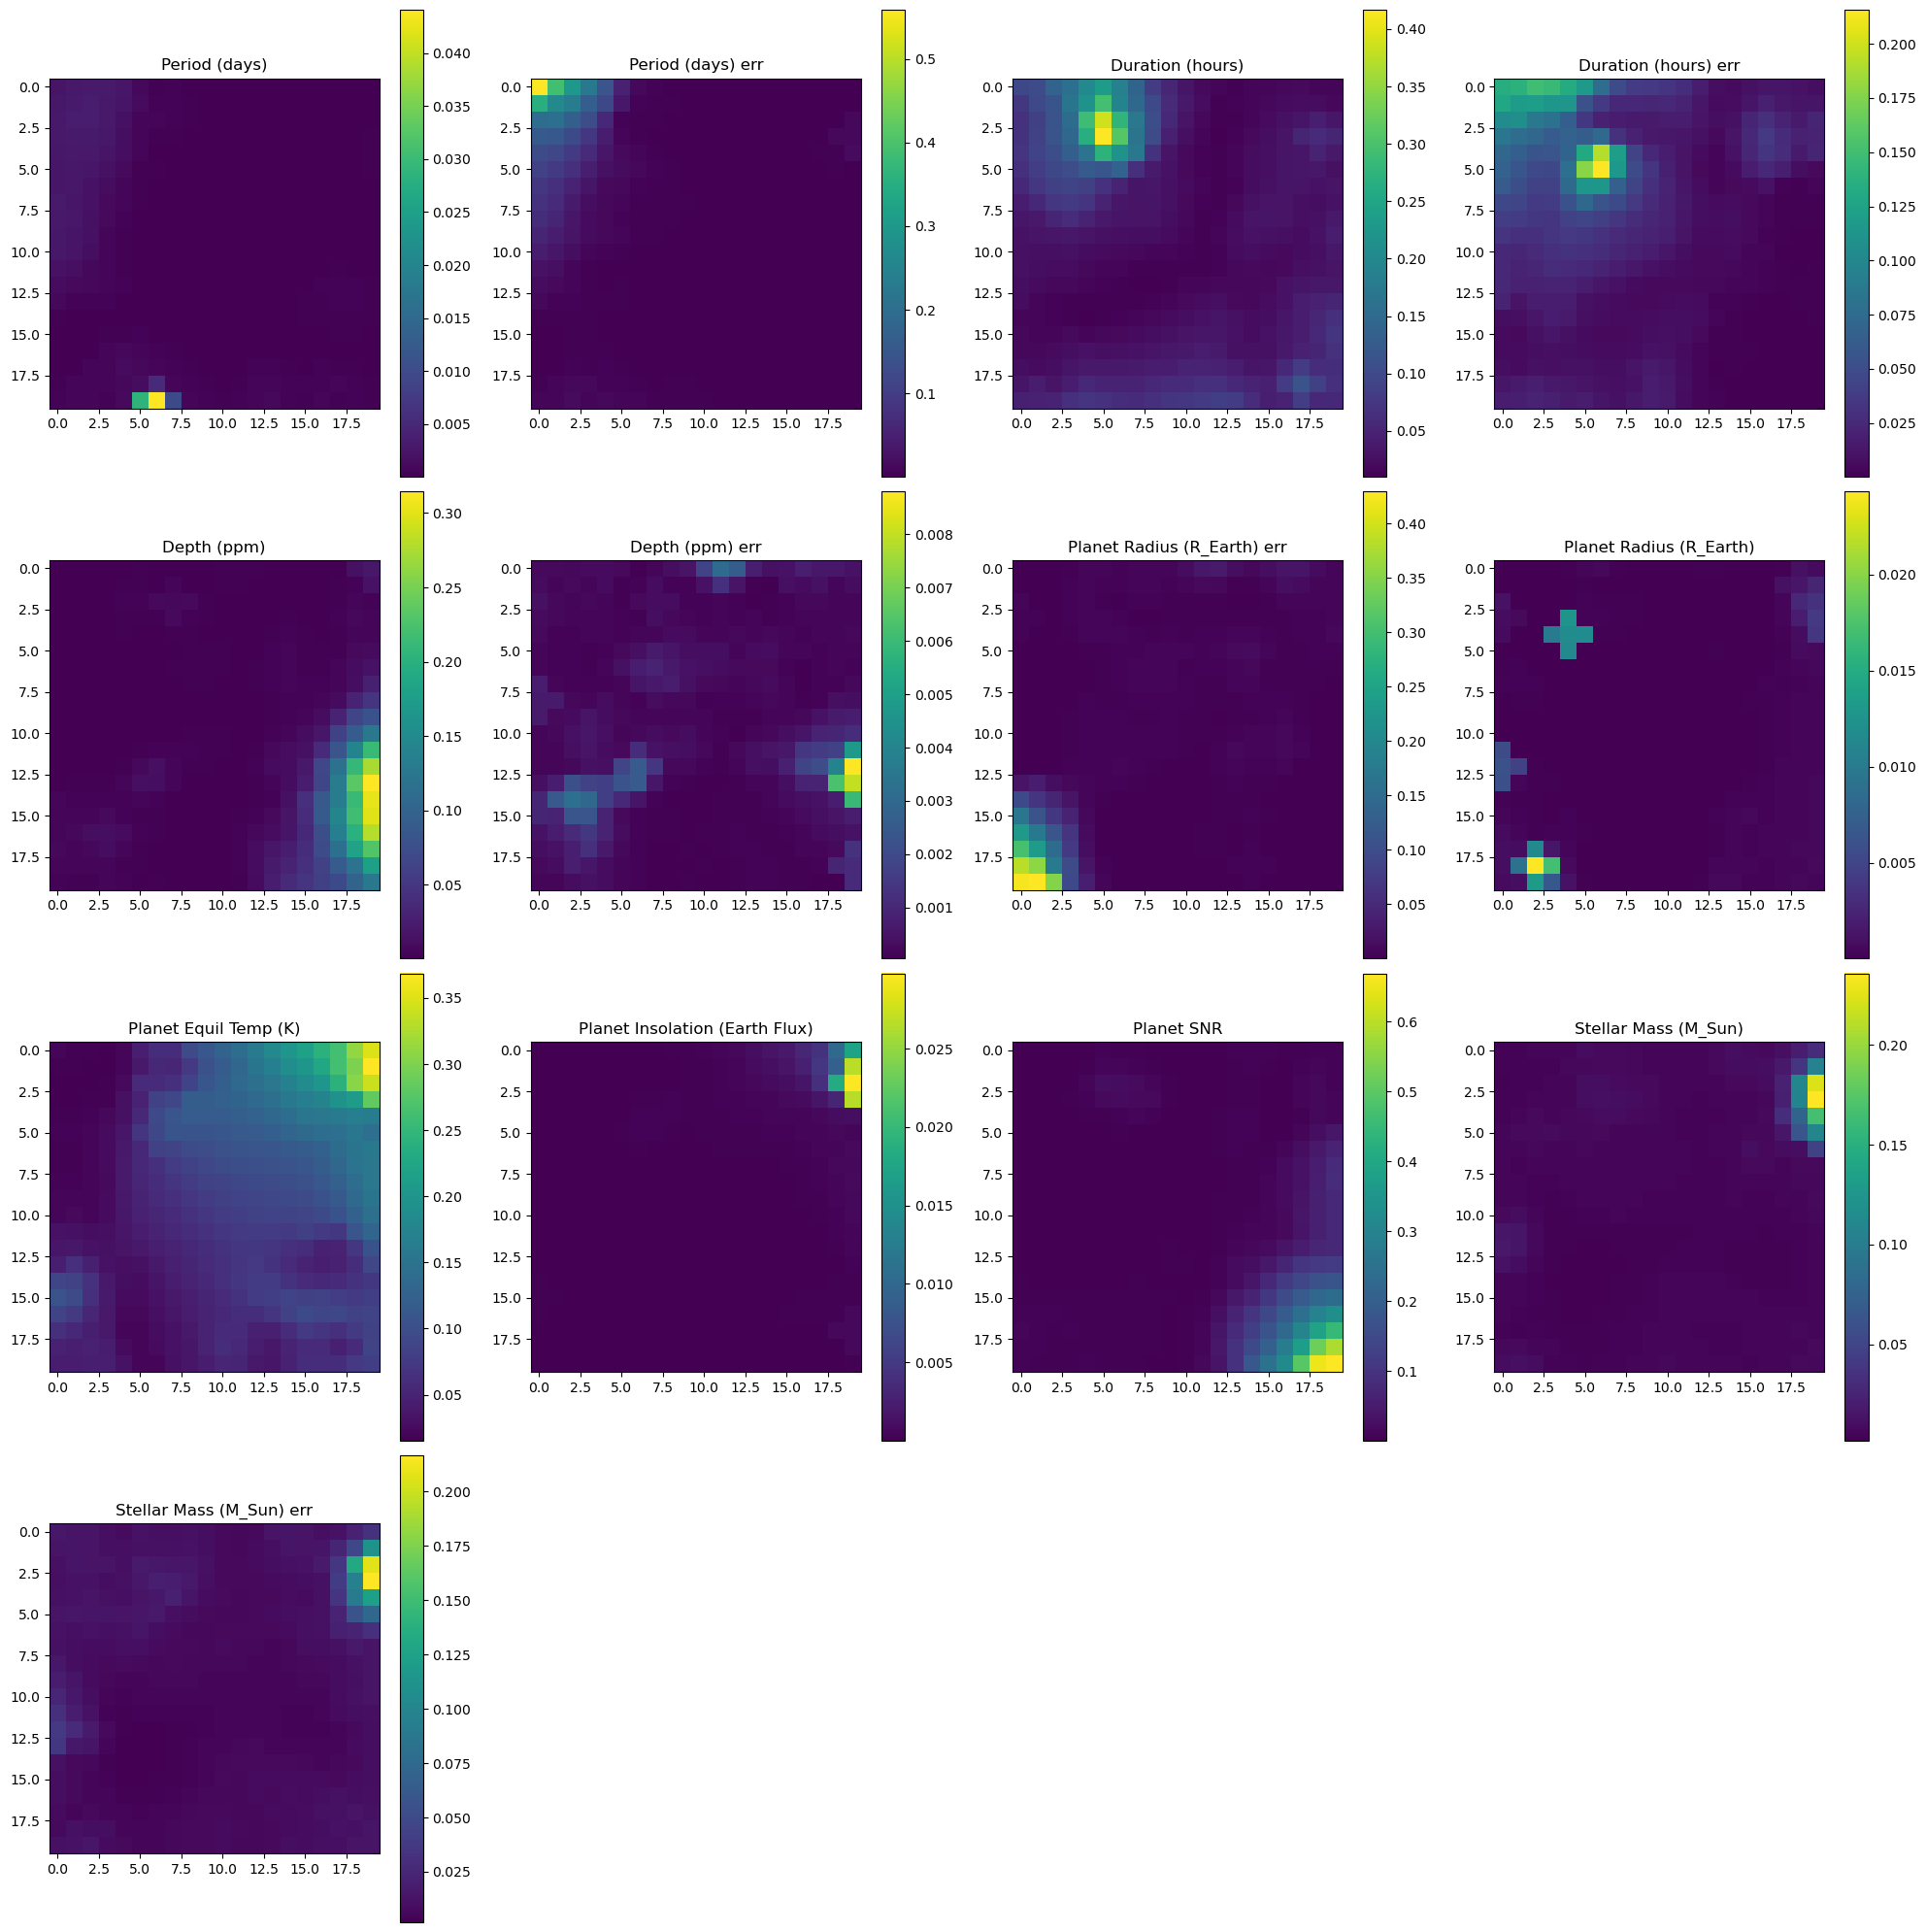

In [18]:
fig = plt.figure(figsize=(20, 20))
View.make_u_slide(component_names=component_names, som=som)
plt.show()

In [19]:
BMUs, BMU_labels = som.calculate_bmu_and_labels()
BMU_label_combinations = list(zip(BMUs, BMU_labels))
BMU_counts = som.bmu_occurrences()
coord_label = som.compute_coordinates_label()
som.print_bmu_label()

(15, 7) -> Planet:  86, False Planet:   0
(6, 12) -> Planet:  74, False Planet:   0
(12, 1) -> Planet:   0, False Planet:  11
(14, 5) -> Planet:  53, False Planet:   0
(5, 8)  -> Planet:   0, False Planet:  14
(9, 7)  -> Planet:  31, False Planet:   0
(6, 10) -> Planet:  39, False Planet:   0
(1, 13) -> Planet:   0, False Planet:  41
(15, 0) -> Planet:  10, False Planet:   0
(19, 16)-> Planet:   0, False Planet:  34
(12, 7) -> Planet:  35, False Planet:   0
(18, 6) -> Planet:  26, False Planet:   0
(15, 13)-> Planet:  37, False Planet:   0
(15, 6) -> Planet:  87, False Planet:   0
(9, 8)  -> Planet:  47, False Planet:   0
(12, 13)-> Planet:   0, False Planet:  15
(8, 17) -> Planet:  17, False Planet:   0
(11, 2) -> Planet:   0, False Planet:  14
(14, 7) -> Planet: 122, False Planet:   0
(14, 18)-> Planet:   0, False Planet:  10
(8, 18) -> Planet:   0, False Planet:   9
(12, 11)-> Planet:  60, False Planet:   0
(12, 6) -> Planet:  43, False Planet:   0
(11, 3) -> Planet:  48, False Plan

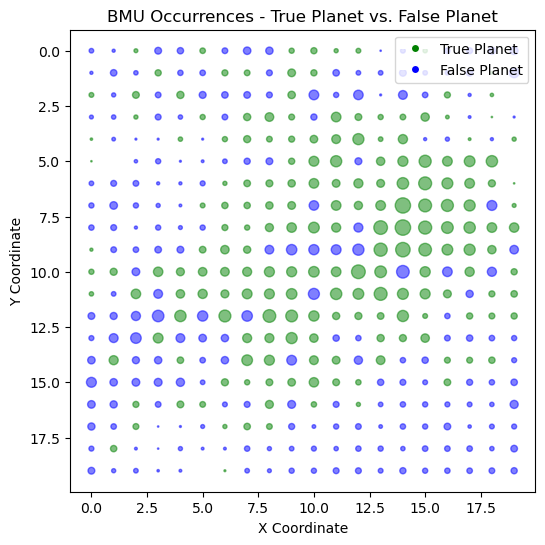

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
View.plot_bmu_occurrences_with_planet_noplanet(ax=ax, coord_label=coord_label)
plt.show()

In [21]:
map = som.collecting_labels(X_train, y_train)
label_map = som.construct_label_map(X_train, y_train)
label_map_kw = som.construct_label_map_weighed(X_train, y_train)
label_map_kcw = som.construct_label_map_occ_weighed(X_train, y_train)

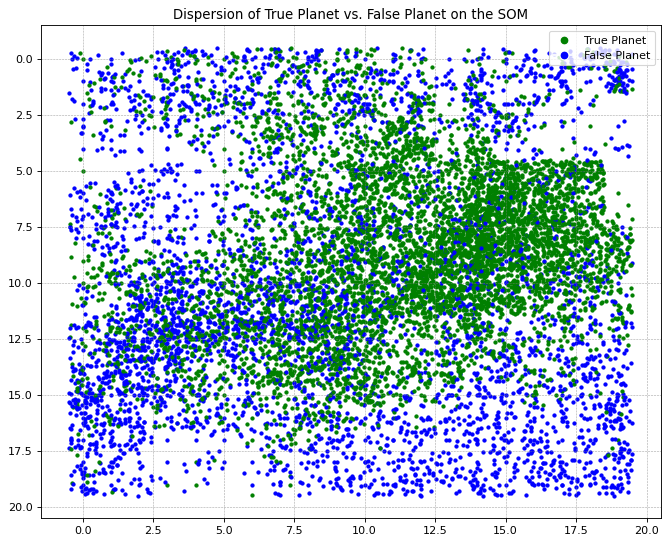

In [22]:
View.plot_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, BMU_labels=BMU_labels)

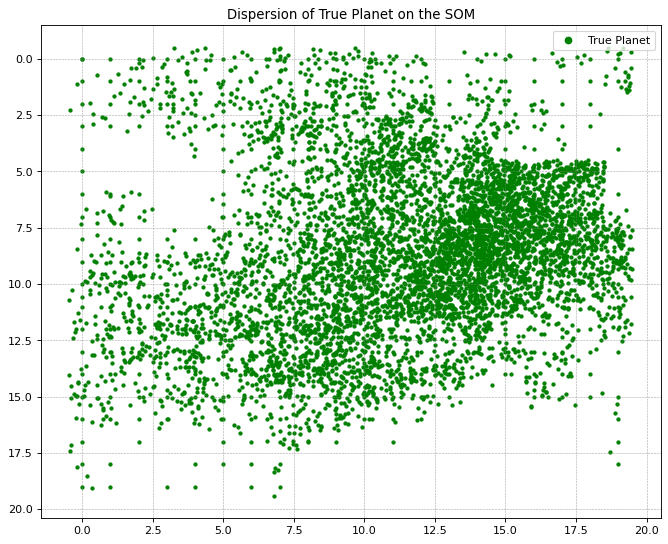

In [23]:
View.plot_class_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, 
                                              BMU_labels=BMU_labels, classes=1)

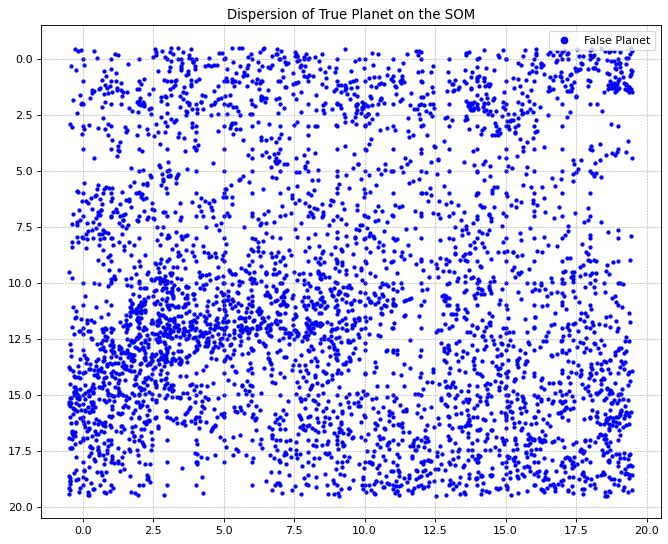

In [24]:
View.plot_class_dispersion_observation_on_som(X_train=X_train, BMUs=BMUs, 
                                              BMU_labels=BMU_labels, classes=0)

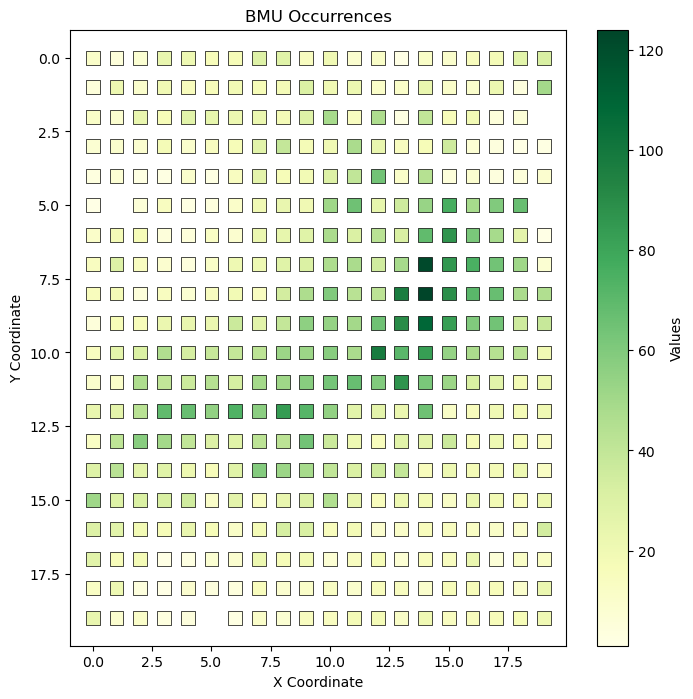

In [25]:
x_coords, y_coords, counts_occ = som.compute_occurrences_plot()

plt.figure(figsize=(8, 8))
sc = plt.scatter(x_coords, y_coords, c=counts_occ, cmap='YlGn', 
                 s=100, marker='s', edgecolors='black', linewidths=0.5)
plt.colorbar(sc, label='Values')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('BMU Occurrences')
plt.gca().invert_yaxis()
plt.show()

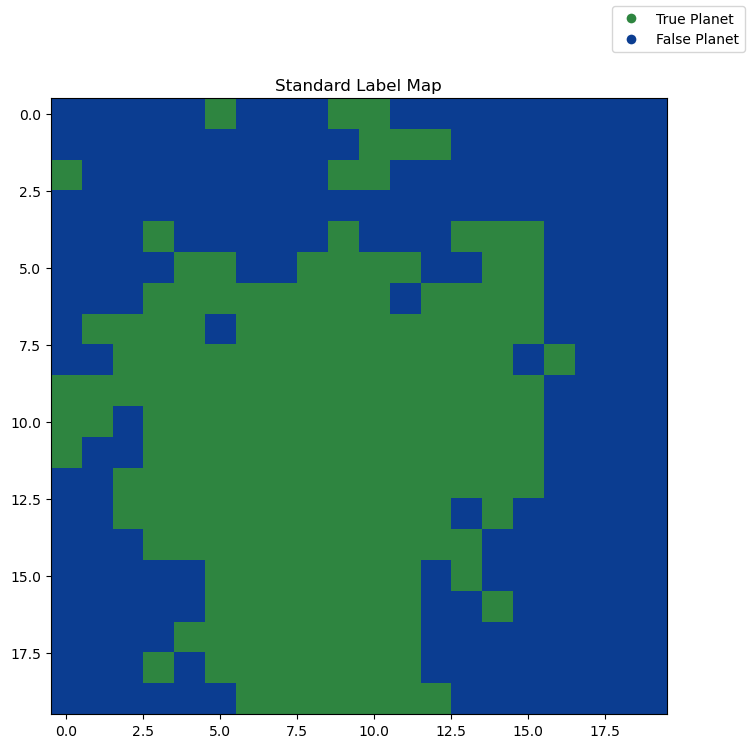

In [26]:
title = ('Standard Label Map')
View.plot_label_map(label_map=label_map, title=title)

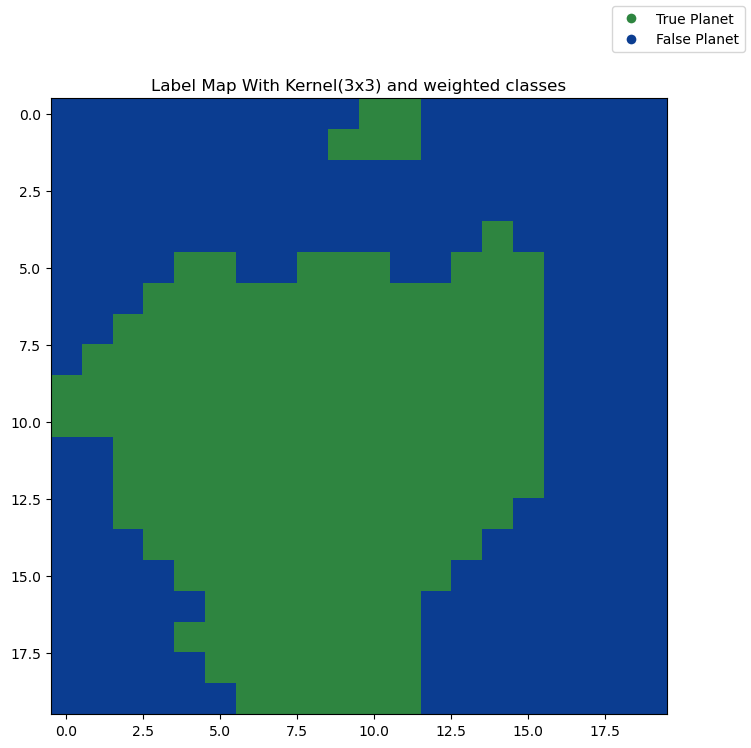

In [27]:
title = ('Label Map With Kernel(3x3) and weighted classes')
View.plot_label_map(label_map=label_map_kw, title=title)

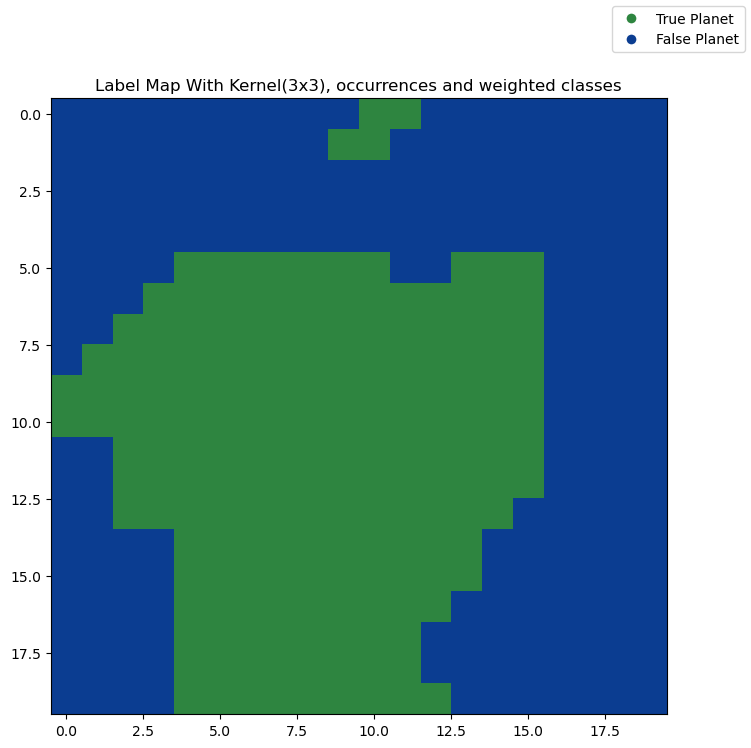

In [28]:
title = ('Label Map With Kernel(3x3), occurrences and weighted classes')
View.plot_label_map(label_map=label_map_kcw, title=title)

Accuracy: 0.7528985507246376
F1-score: 0.8064699205448354
Precision: 0.7660377358490567
Recall: 0.8514080287597364
cm:  [[ 657  434]
 [ 248 1421]]


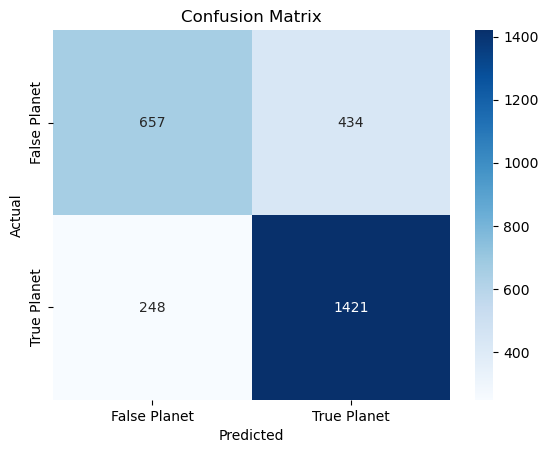

In [29]:
predicted = som.predict(X_train=X_train, y_train=y_train, X_test=X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7489130434782608
F1-score: 0.8008048289738431
Precision: 0.7696132596685082
Recall: 0.8346315158777711
cm:  [[ 674  417]
 [ 276 1393]]


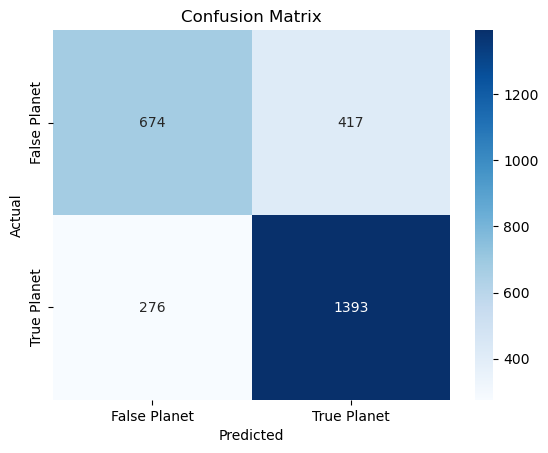

In [30]:
predicted = som.predict_kw(X_train, y_train, X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7463768115942029
F1-score: 0.7987349051178838
Precision: 0.7678275290215588
Recall: 0.8322348711803476
cm:  [[ 671  420]
 [ 280 1389]]


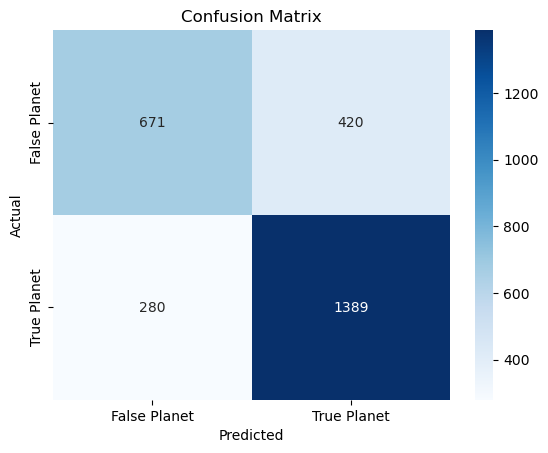

In [31]:
predicted = som.predict_kcw(X_train, y_train, X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)

Accuracy: 0.7536231884057971
F1-score: 0.8052691867124857
Precision: 0.7712561711464618
Recall: 0.8424206111443978
cm:  [[ 674  417]
 [ 263 1406]]


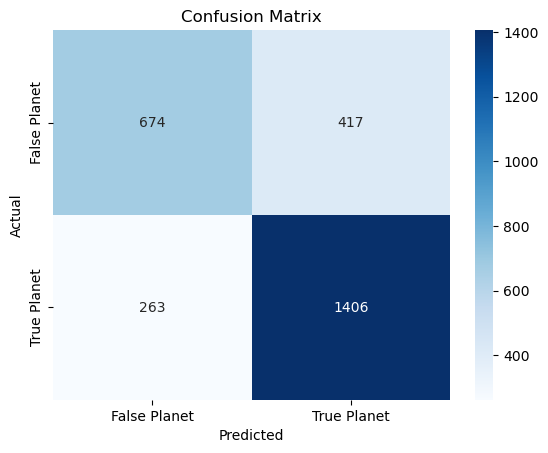

In [32]:
predicted = som.predict_knn(X_test, K=None)

cm = confusion_matrix(y_test, predicted)
print('Accuracy:', accuracy_score(y_test, predicted))
print('F1-score:', f1_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print("cm: ", cm)
plot_confusion_matrix(cm=cm)